## Fastai: Image Augmentation

Fastai is a deep learning library built on top of PyTorch. It has a goal of integrating/encapsulating the SOTA techniques such that they are widely accessible, often in on ly a few lines of codes.

In this tour, I will walk through and focus on its image data augmentation interface. This is one of the important tool for regularizing your network, especially if you have only very little data.

## Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.basics import *
from fastai.vision import *

## Path

In [ ]:
PATH = Path.cwd()
PATH.ls()

[PosixPath('/home/achen/workspace/acnbs/studies/fastai-add-augmentation/.ipynb_checkpoints'),
 PosixPath('/home/achen/workspace/acnbs/studies/fastai-add-augmentation/fastai-add-augmentation.ipynb'),
 PosixPath('/home/achen/workspace/acnbs/studies/fastai-add-augmentation/get_transforms.jpg')]

In [ ]:
filename = PATH/'sniper_target_vector.jpg'

In [ ]:
# Plotting configurations
plt.style.use(['dark_background'])
rows,cols,width,height = 2,4,12,6

In [ ]:
def get_ex(): return open_image(filename)

def plot_tfms(tfms, padding_mode='reflection'):
    return [get_ex().apply_tfms(tfms, size=224, padding_mode=padding_mode).show(ax=ax)
             for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())];

def clean_tfms():
    try:
        global tfms
        del tfms
        gc.collect()
    except NameError: pass

In [ ]:
get_ex().shape

torch.Size([3, 229, 229])

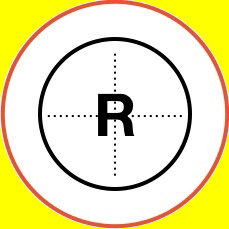

In [ ]:
get_ex()

`get_transform()` declares a default set of transformations. Most of them have specific values and a span with a specified probablity, `p_affine` or `p_lighting`. It will picked at random with probabilty `p_`. To illustrate this, please run the following cell few times to generate a variety of samples to get a feel of what they do.

In [ ]:
tfms = get_transforms(); tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0

`get_transforms()` returns a 2-tuple. The first is a list of transforms for the training set and the second is for validation set.

Even though Fastai folks recommended the default `get_transform()s` or by tweaking its parameters will cover lots of cases, but still, it is very important to take a look at how your images get transformed before training. Sometimes, the default may not be appropriate and can lead to worse performance. This will rely on your own intuition and domain expertise to make decisions.

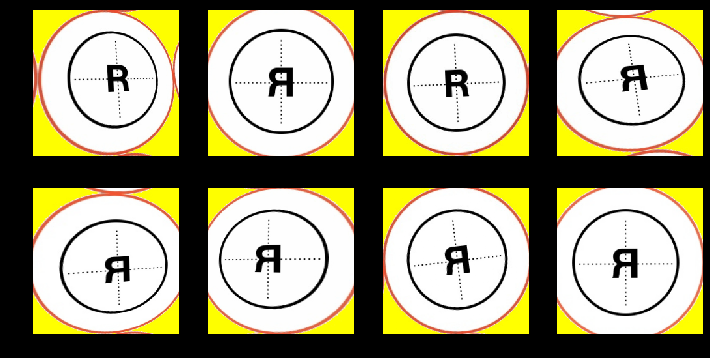

In [ ]:
plot_tfms(tfms[0]);

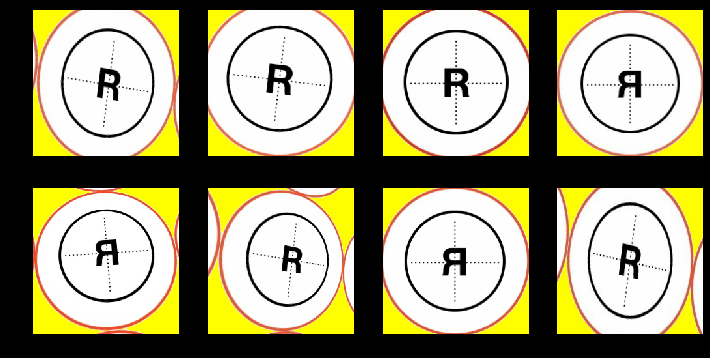

In [ ]:
plot_tfms(tfms[0]);

### Configure my own transformation

In [ ]:
??rotate

Signature:       rotate(degrees: <function uniform at 0x7f1df5b8d048>) -> fastai.vision.image.Image
Call signature:  rotate(*args: Any, p: float = 1.0, is_random: bool = True, **kwargs: Any) -> fastai.vision.image.Image
Type:            TfmAffine
String form:     TfmAffine (rotate)
File:            ~/workspace/fastaidev/fastai/vision/transform.py
Source:         
def _rotate(degrees:uniform):
    "Rotate image by `degrees`."
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]
Class docstring: Decorator for affine tfm funcs.
Init docstring:  Create a transform for `func` and assign it an priority `order`, attach to `Image` class.
Call docstring:  Calc now if `args` passed; else create a transform called prob `p` if `random`.


Rotate has an argument `degrees` which is argument type of uniform. You will need to provide a value or a range represented by a tuple from which a random value can be drawn. The call signature also listed out more params (e.g. p: float) its superclass can take (which implies rotate can also take). The `p` param states that this transform is to be applied for probability p. Also make a mental note of the return type, which is **TfmAffine**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


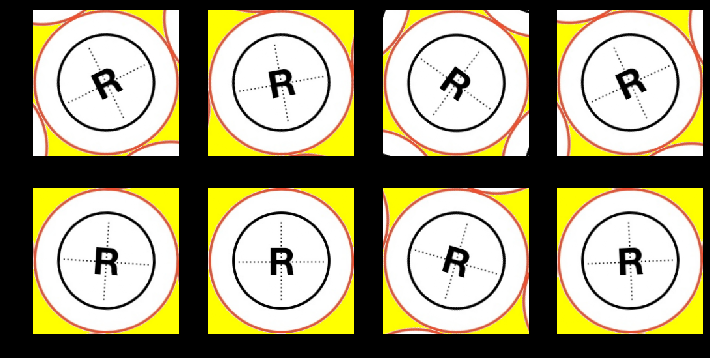

In [ ]:
tfms = [rotate(degrees=(-45.,45.), p=0.9)]
plot_tfms(tfms);

So I have applied a rotation randomly picked from range `-45~45` at a probability `0.9` and ONLY that and nothing else, since we are configuring our own transform. Note that there are more parameters such as `size=224` thats not part of tfms. This is a design choice fastai seemed to make. Conceptually, resizing is not considered to to be a dynamic data augmentation by some. But you can argue it is if you think about the multi-resolution fine-tuing mentioned in fastai lesson.

Depending on your runs (run the above cell multiple times if needed), you may see the padding that is `reflect`. This may be highly problematic if you work on **counting** task, or object localization. There are 2 other popular choieces:
- zero-padding
- border (fill with same pixel at the edge of the image, or pixel continuation if you'd like)

Padding can be specified in `padding_mode` parameter

Let's try `90` degree at random probability `0.5`

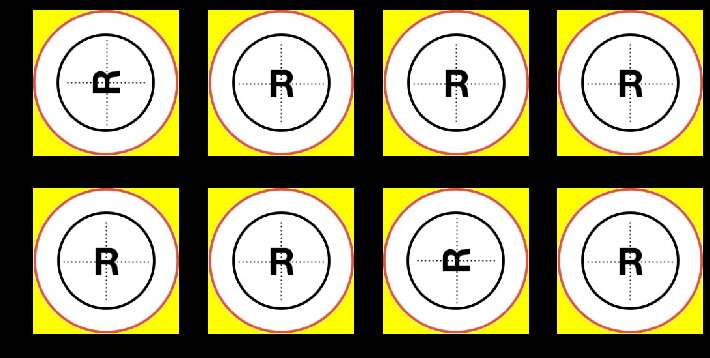

In [ ]:
tfms = [rotate(degrees=90, p=0.5)]
plot_tfms(tfms);

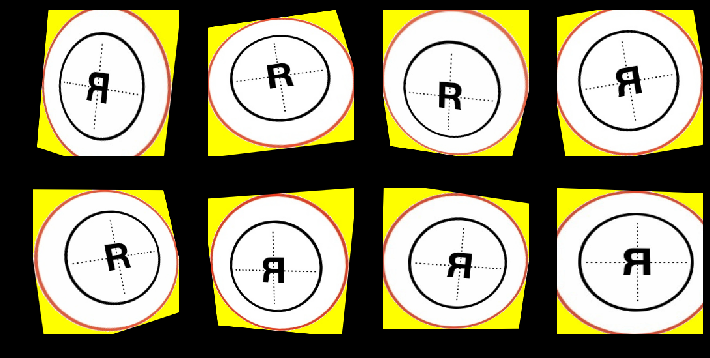

In [ ]:
tfms = get_transforms()[0]
plot_tfms(tfms, padding_mode='zeros');

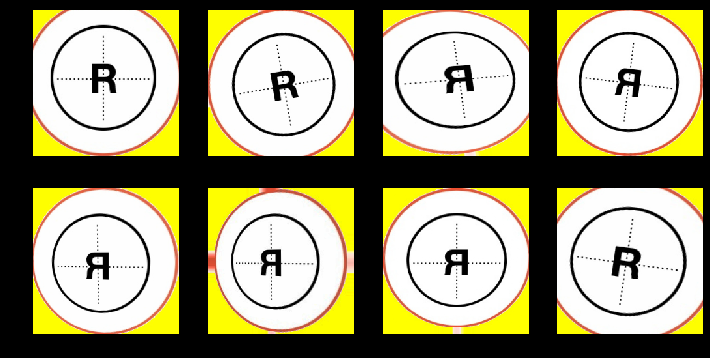

In [ ]:
tfms = get_transforms()[0]
plot_tfms(tfms, padding_mode='border');

Lets try the transform *rand_resize_crop* , we will do it carelessly to provoke an error intentionally, and then work to fix it easily.

In [ ]:
??rand_resize_crop

Signature: rand_resize_crop(size: int, max_scale: float = 2.0, ratios: Tuple[float, float] = (0.75, 1.33))
Source:   
def rand_resize_crop(size:int, max_scale:float=2., ratios:Tuple[float,float]=(0.75,1.33)):
    "Randomly resize and crop the image to a ratio in `ratios` after a zoom of `max_scale`."
    return [zoom_squish(scale=(1.,max_scale,8), squish=(*ratios,8), invert=(0.5,8), row_pct=(0.,1.), col_pct=(0.,1.)), 
            crop(size=size)]
File:      ~/workspace/fastaidev/fastai/vision/transform.py
Type:      function


In [ ]:
tfms = [rotate(degrees=(-45.,45.), p=0.9)]; tfms

[RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=0.9, resolved={}, do_run=True, is_random=True)]

In [ ]:
tfm = rand_resize_crop(224, max_scale=1.5, ratios=(0.7,1.2)); tfm

[RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 1.5, 8), 'squish': (0.7, 1.2, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmPixel (crop), kwargs={'size': 224}, p=1.0, resolved={}, do_run=True, is_random=True)]

In [ ]:
tfms.append(tfm); tfms

[RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=0.9, resolved={}, do_run=True, is_random=True),
 [RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 1.5, 8), 'squish': (0.7, 1.2, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 224}, p=1.0, resolved={}, do_run=True, is_random=True)]]

AttributeError: 'list' object has no attribute 'tfm'

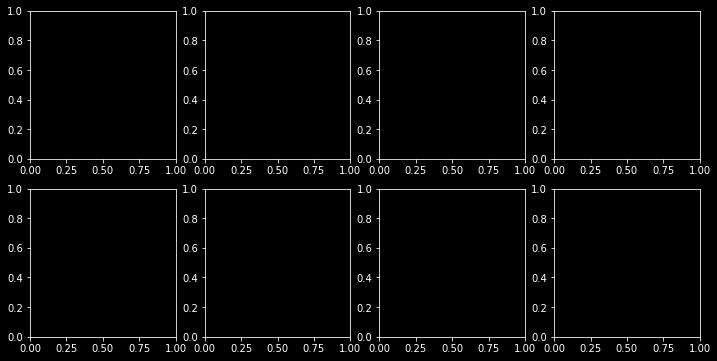

In [ ]:
plot_tfms(tfms)

What is happening?? This is the 1st error we encountered in this tour. If you go back to look at the ?? help for this transform, you will notice the return type is not a transform, it is a list of transforms. This is actually great. It is hinting you transformation can be composed. Take a look at tfms

Let's clear the tfms we created above and generate a new one by extending `tfm` to `tfms`

In [ ]:
clean_tfms()
tfms = [rotate(degrees=(-45.,45.), p=0.9)]
tfm = rand_resize_crop(224, max_scale=1.5, ratios=(0.7,1.2))
tfms.extend(tfm); tfms

[RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=0.9, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 1.5, 8), 'squish': (0.7, 1.2, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmPixel (crop), kwargs={'size': 224}, p=1.0, resolved={}, do_run=True, is_random=True)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


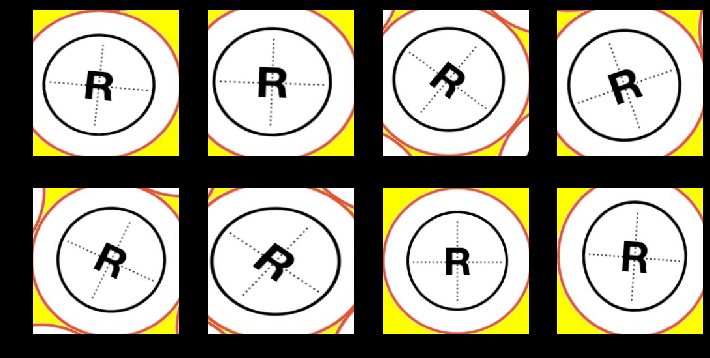

In [ ]:
plot_tfms(tfms);

In [ ]:
??brightness

Signature:       brightness(x, change: <function uniform at 0x7f1df5b8d048>) -> fastai.vision.image.Image
Call signature:  brightness(*args: Any, p: float = 1.0, is_random: bool = True, **kwargs: Any) -> fastai.vision.image.Image
Type:            TfmLighting
String form:     TfmLighting (brightness)
File:            ~/workspace/fastaidev/fastai/vision/transform.py
Source:         
def _brightness(x, change:uniform):
    "Apply `change` in brightness of image `x`."
    return x.add_(scipy.special.logit(change))
Class docstring: Decorator for lighting tfm funcs.
Init docstring:  Create a transform for `func` and assign it an priority `order`, attach to `Image` class.
Call docstring:  Calc now if `args` passed; else create a transform called prob `p` if `random`.


Again, not the `change` param has keyword `uniform`, so we guess it is a range represented by a tuple. If you specify only 1 number in the tuple, it will use that value, otherwise, it is interpreted as a range.

In [ ]:
brightness_tfm = brightness(change=0.1, p=1.0)
tfms.append(brightness_tfm)

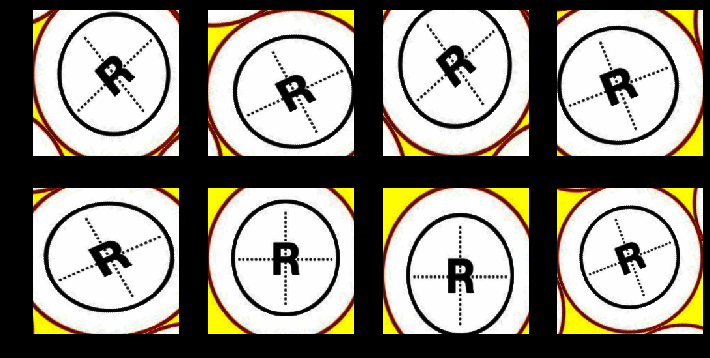

In [ ]:
plot_tfms(tfms, padding_mode='zeros');

In [ ]:
tfms = tfms[:-1] # drop the prior brightness transform
brightness_tfm = brightness(change=(0.99), p=1.0)
tfms.append(brightness_tfm)

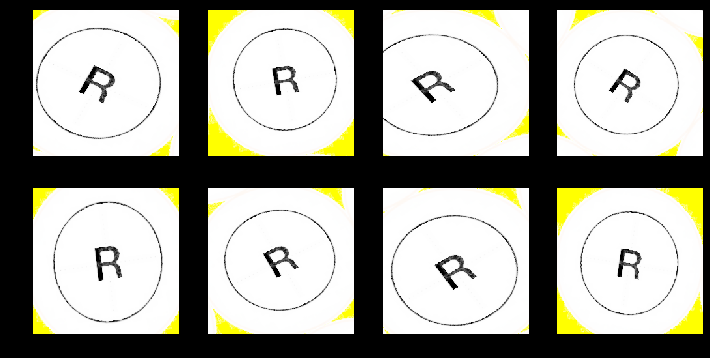

In [ ]:
plot_tfms(tfms);

### Customize Your Own Transformation

It is useful to browse fastai/visoin/transform.py to see how mage transforms are tailor-made defined. Find the one that is closest to the one you would like to add, and use that as a guide to write your own. I will demostrate two example here, `rot90` and `gaussian_blur`.

#### Customize `rot90` by using `affine` or `pixel` tranform in `Fastai::Image` class

Let's look at a existing transformation, `dihedral`. You see this transformation will randomly result in 8 different orientation that are reflections and rotations.

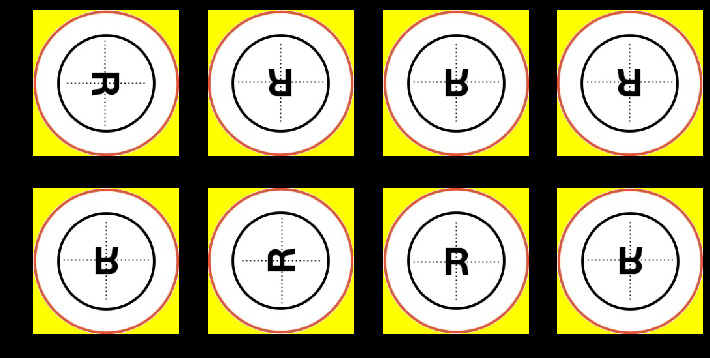

In [ ]:
clean_tfms()
tfms = [dihedral_affine()]
plot_tfms(tfms);

Let say you would like a new transform that `rotation` only in 0, 90, 180 and 270 degree, like the one in `numpy`, `np.rot90()`.

1.) Create a method with param `k`, which is the result of a random sampling of integer of 0 through 3.
2.) Wrapped with `TfmAffine` so our customized function `_rot90_affine` will replace the one in `Image::affine`

In [ ]:
#export
def _rot90_affine(k:partial(uniform_int, 0, 3)):
    "Randomly rotate `x` image based on `k` as in np.rot90"
    if k%2 == 0:
        x = -1. if k&2 else 1.
        y = -1. if k&2 else 1.
        
        return [[x, 0, 0.],
                [0, y, 0],
                [0, 0, 1.]]
    else:
        x = 1. if k&2 else -1.
        y = -1. if k&2 else 1.
        
        return [[0, x, 0.],
                [y, 0, 0],
                [0, 0, 1.]]

rot90_affine = TfmAffine(_rot90_affine)

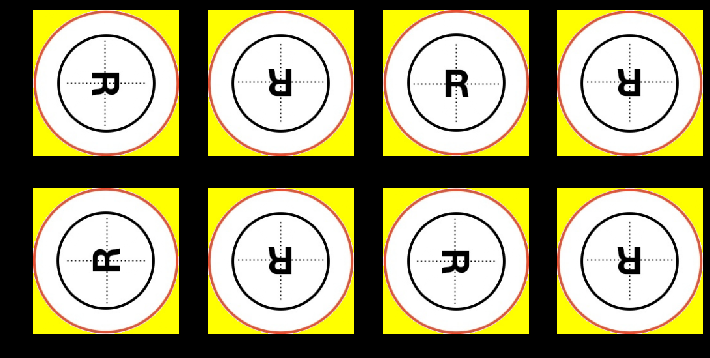

In [ ]:
tfms = [rot90_affine()]
plot_tfms(tfms);

Here is another method but do the same `np.rot90` work by using the matrix manipulation

In [ ]:
#export
def _rot90(x, k:partial(uniform_int,0,3)):
    "Randomly flip `x` image based on `k` as in np.rot90"
#     print("k={}".format(k))
    if k == 1:
        x = torch.flip(x, [2])
        x = x.transpose(1, 2)
    elif k == 2:
        x = torch.flip(x, [2, 1])
    elif k == 3:
        x = torch.flip(x, [1])
        x = x.transpose(1, 2)
    
    return x.contiguous()
    
rot90 = TfmPixel(_rot90)

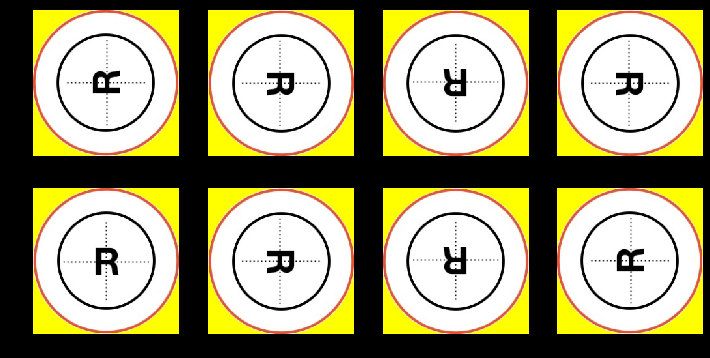

In [ ]:
tfms = [rot90()]
plot_tfms(tfms);

#### Customize Shear

In [ ]:
#export
def _shear(degrees:uniform):
    "Shear image by `degrees`."
    shear = degrees * math.pi / 180
    return [[1., -sin(shear), 0.],
            [0., cos(shear), 0.],
            [0., 0., 1.]]

shear = TfmAffine(_shear)

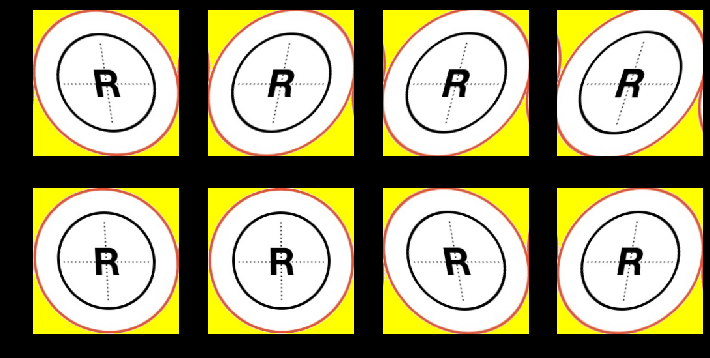

In [ ]:
tfms = [shear(degrees=(-20., 20.))]
plot_tfms(tfms, padding_mode="zeros");

#### Customize Gaussian blur

We will use PIL ImageFilter's Gaussian Blur. Since this library works with numpy, we have to add quite a bit of conversions. This snippet shows it is not difficult to add a new image transform and we can easily leverage from popular python modules such as PIL. However, you may want to do this more efficiently, you will have to re-implement this as a kernel operation in pytorch working directly with torch tensor (without going through numpy).

In [ ]:
#export
import PIL
from PIL import ImageFilter

def _gaussian_blur(x, radius:uniform):
    y = x.numpy()*255
def _gaussian_blur(x, radius:uniform):
    y = (x.numpy()*255.).astype(np.uint8).transpose((1, 2, 0))
    img = PIL.Image.fromarray(y)
    img = img.filter(ImageFilter.GaussianBlur(radius=radius))
    x = np.array(img).transpose((2, 0, 1))
    
    return torch.tensor(x/255., dtype=torch.float32)

gaussian_blur = TfmPixel(_gaussian_blur)

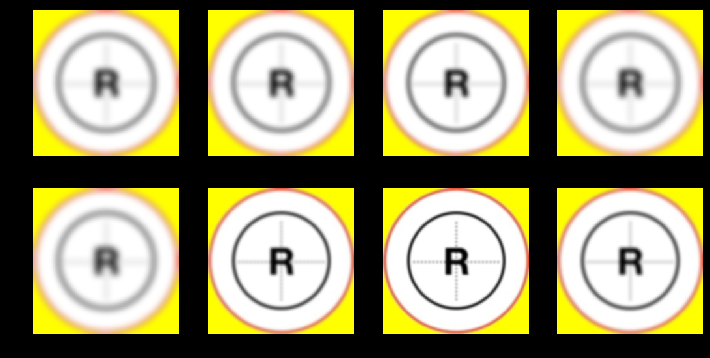

In [ ]:
tfms = [gaussian_blur(radius=(0.5, 5.0))]
plot_tfms(tfms);

## EON